In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
!pip install scikit-learn --upgrade  # Upgrade scikit-learn to the latest version


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [87]:
# Loading the data
df=pd.read_csv('parkingLot (1).csv')

In [88]:
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


We are going to do this for part (a) first then part (b), applying two outliers smoothing for (a). And in (b), we will first apply a missing value imputation strategy, then as the second technique, we will try an outlier smoothing technique.

# Techniques for Part (a) 

In [89]:
df_first=df['vehicle_no']
df_first.sort_values()

12473    0HFB7657
67395    0HLW6417
94687    0HNH1376
7039     1HHN8789
62732    1HSF6006
           ...   
98473         NaN
98474         NaN
98475         NaN
98476         NaN
98477         NaN
Name: vehicle_no, Length: 106694, dtype: object

In [90]:
frequency_df = df.groupby(['timestamp', 'camera_id']).size().reset_index(name='frequency')
df1=frequency_df[frequency_df['camera_id']==1]
df2=frequency_df[frequency_df['camera_id']==2]

In [91]:
# using the timestamp of df1, group the data by each day...basically sum the frequency of each day
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
#Only sum the 'frequency' column, excluding the 'timestamp' column
df1_daywise=df1.groupby(df1['timestamp'].dt.date)['frequency'].sum().reset_index()
df1_daywise

C:\Users\Maadurga computer\AppData\Local\Temp\ipykernel_22132\4156867863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['timestamp'] = pd.to_datetime(df1['timestamp'])


,timestamp,frequency
0,2024-09-12,886
1,2024-09-13,809
2,2024-09-14,925
3,2024-09-15,1073
4,2024-09-16,843
...,...,...
58,2024-11-09,906
59,2024-11-10,944
60,2024-11-11,828
61,2024-11-12,806


### Method 1: Simple Moving average ( actual values filled in NaN created by moving average)

In [92]:
#### Lets smooth the data to remove outliers using MA for the complete data of df1_daywise
df1_smoothed1=df1_daywise.copy()
df1_smoothed1['frequency'] = df1_smoothed1['frequency'].rolling(window=3).mean()

#### fill nan with actual values
df1_smoothed1['frequency'].fillna(df1_daywise['frequency'], inplace=True)
df1_smoothed1

C:\Users\Maadurga computer\AppData\Local\Temp\ipykernel_22132\1343092523.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1_smoothed1['frequency'].fillna(df1_daywise['frequency'], inplace=True)


,timestamp,frequency
0,2024-09-12,886.000000
1,2024-09-13,809.000000
2,2024-09-14,873.333333
3,2024-09-15,935.666667
4,2024-09-16,947.000000
...,...,...
58,2024-11-09,837.000000
59,2024-11-10,882.666667
60,2024-11-11,892.666667
61,2024-11-12,859.333333


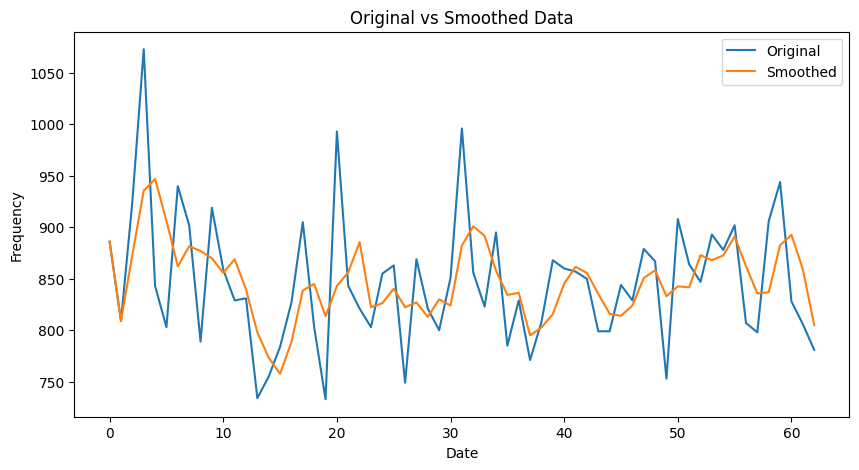

In [93]:
### Lets see how the data changed
plt.figure(figsize=(10, 5))
plt.plot(df1_daywise.index, df1_daywise['frequency'], label='Original')
plt.plot(df1_smoothed1.index, df1_smoothed1['frequency'], label='Smoothed')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Original vs Smoothed Data')
plt.legend()
plt.show()

#### Model Training

In [94]:
from sklearn.model_selection import train_test_split # Changed import to train_test_split
train, test = train_test_split(df1_smoothed1, test_size=0.15, shuffle=False)

In [95]:
# Final model using ets
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model2 = ExponentialSmoothing(train['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit2 = model2.fit()

MAPE: 2.4039952957116966
MASE: 0.3027131306581432


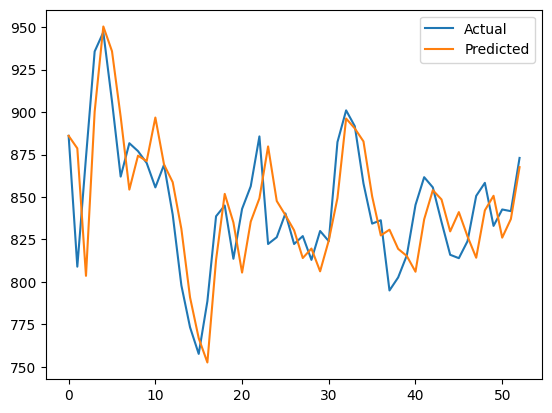

In [96]:
# using ets model, predict, print accuracy and plot on training set
predictions2=model_fit2.predict(start=train.index[0], end=train.index[-1])
# print(model_fit2.summary())

#print accuracy
mape2 = np.mean(np.abs((train['frequency'].values - predictions2) / train['frequency'].values)) * 100
print('MAPE:', mape2)

# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(train['frequency'].values - predictions2))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(train['frequency'], label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.show()

MAPE: 2.0209064950983513
MASE: 0.2548056015815934


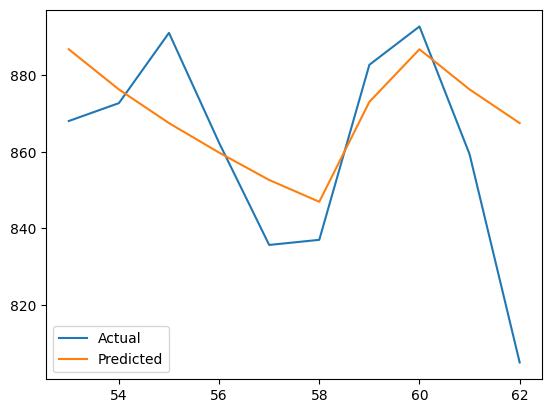

In [97]:
# predict and plot
predictions = model_fit2.predict(start=test.index[0], end=test.index[-1])

#print mape
mape = np.mean(np.abs((test['frequency'].values - predictions) / test['frequency'].values)) * 100
print('MAPE:', mape)
# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(test['frequency'].values - predictions))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(test['frequency'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


Looking at the MAPE and MASE, this model performs much better than the actual one in part (a). Hence moving average technique significantly improves the prediction.

#### Forecast for next seven days.

In [98]:
### same model as before, fitted on complete data
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model3 = ExponentialSmoothing(df1_smoothed1['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit3 = model3.fit()

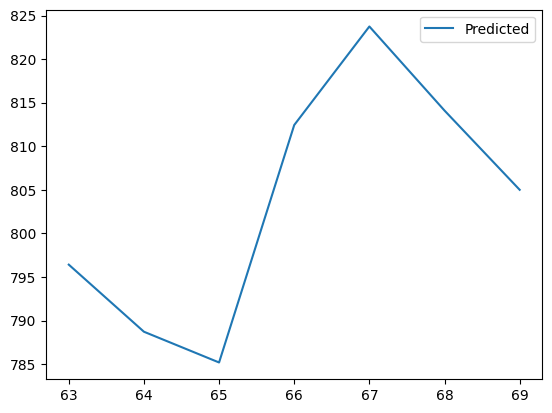

63    796.411687
64    788.711485
65    785.182179
66    812.433797
67    823.745538
68    814.095205
69    805.000001
dtype: float64

In [99]:
### Final forecast for the next 7 days
final_predictions = model_fit3.predict(start=df1_daywise.index[-1] + 1, end=df1_daywise.index[-1] + 7)
plt.plot(final_predictions, label='Predicted')
plt.legend()
plt.show()
final_predictions

The above values have been provided in the report.

### Method 2: Median Absolute Deviation

In [100]:
df1_smoothed2=df1_daywise.copy()

In [101]:
# Function to calculate Median Absolute Deviation
def mad(series):
    median = np.median(series)
    mad_value = np.median(np.abs(series - median))
    return mad_value

In [102]:

# Calculate MAD
mad_value = mad(df1_smoothed2['frequency'])

# Define the threshold for outlier detection
threshold = 3  # This can be adjusted

# Calculate the median of the series
median_value = np.median(df1_smoothed2['frequency'])

# Identify outliers
outliers = df1_smoothed2['frequency'][(np.abs(df1_smoothed2['frequency'] - median_value) > threshold * mad_value)]

# Smooth outliers by replacing them with the median
df1_smoothed2['frequency'] = df1_smoothed2['frequency'].where(~df1_smoothed2['frequency'].isin(outliers), median_value)

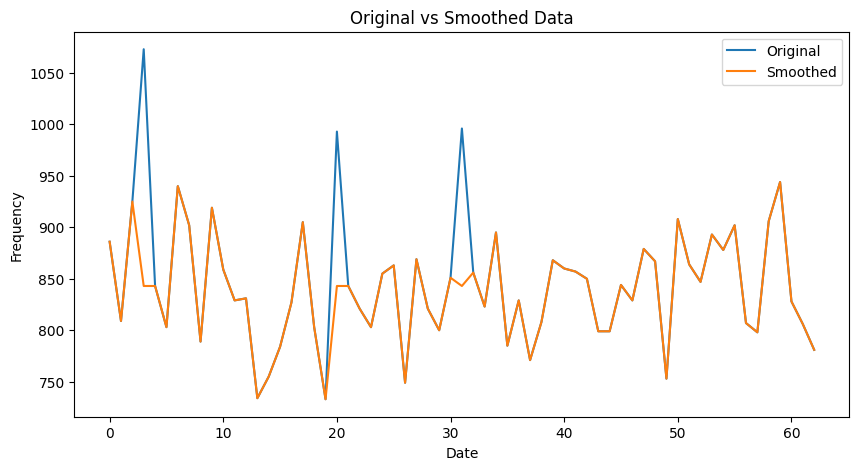

In [103]:
### Lets see how the data changed
plt.figure(figsize=(10, 5))
plt.plot(df1_daywise.index, df1_daywise['frequency'], label='Original')
plt.plot(df1_smoothed2.index, df1_smoothed2['frequency'], label='Smoothed')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Original vs Smoothed Data')
plt.legend()
plt.show()

Clearly the outliers have been reduced significantly.


#### Model Training

In [104]:
from sklearn.model_selection import train_test_split # Changed import to train_test_split
train, test = train_test_split(df1_smoothed2, test_size=0.15, shuffle=False)

In [105]:
# Final model using ets
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model2 = ExponentialSmoothing(train['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit2 = model2.fit()

MAPE: 4.046726414460294
MASE: 0.5014346568651499


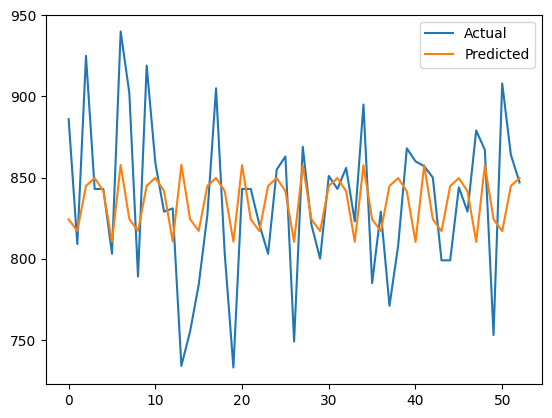

In [106]:
# using ets model, predict, print accuracy and plot on training set
predictions2=model_fit2.predict(start=train.index[0], end=train.index[-1])
# print(model_fit2.summary())

#print accuracy
mape2 = np.mean(np.abs((train['frequency'].values - predictions2) / train['frequency'].values)) * 100
print('MAPE:', mape2)

# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(train['frequency'].values - predictions2))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(train['frequency'], label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.show()

MAPE: 5.164535382309084
MASE: 0.6731293611513258


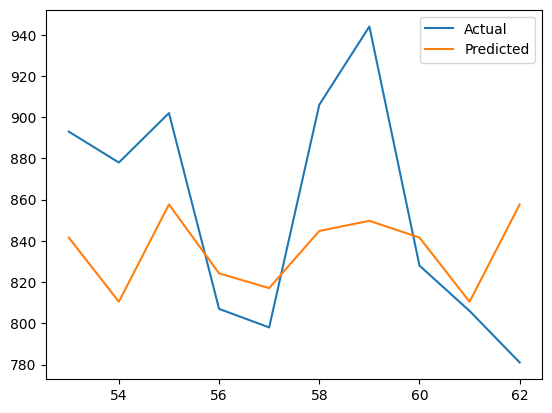

In [107]:
# predict and plot
predictions = model_fit2.predict(start=test.index[0], end=test.index[-1])

#print mape
mape = np.mean(np.abs((test['frequency'].values - predictions) / test['frequency'].values)) * 100
print('MAPE:', mape)
# MASE
naive_forecast_error = np.abs(np.diff(df1_daywise['frequency'])).mean()
mae_model = np.mean(np.abs(test['frequency'].values - predictions))
mase = mae_model / naive_forecast_error
print('MASE:', mase)
#plot
plt.plot(test['frequency'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


Looking at the MAPE and MASE, this model performs much better than the actual one in part (a). Hence moving average technique significantly improves the prediction.

#### Forecast for seven days

In [108]:
### same model as before, fitted on complete data
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model3 = ExponentialSmoothing(df1_smoothed2['frequency'], trend=None, seasonal='mul', seasonal_periods=7)
model_fit3 = model3.fit()

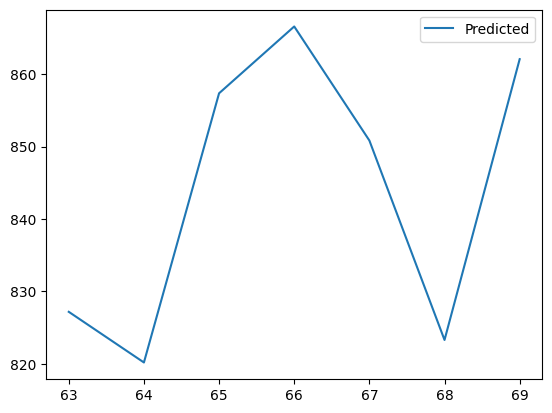

63    827.188219
64    820.193167
65    857.365704
66    866.591426
67    850.845229
68    823.301867
69    862.078779
dtype: float64

In [109]:
### Final forecast for the next 7 days
final_predictions = model_fit3.predict(start=df1_daywise.index[-1] + 1, end=df1_daywise.index[-1] + 7)
plt.plot(final_predictions, label='Predicted')
plt.legend()
plt.show()
final_predictions

This technique does not improve the results

# Techniques for Part (b)

## Method 1: Missing value imputation

Now we are going to try a method to handle the missing values and the outliers, then pass the data to the model of Q2

We want to match the entry and exit of vehicles, which are unmtached due to faulty sensor and maintainence.

In [110]:
### This cell is meant to store given data first
x=pd.to_datetime(df['timestamp']).tolist()

df['date'] = [timestamp.date() for timestamp in x]
dfnew=df.copy()
dfnew['timestamp'] = pd.to_datetime(dfnew['timestamp'])

# # Sort by date and vehicle number
dfnew.sort_values(by=['date', 'vehicle_no', 'timestamp'], inplace=True)
# # Calculate the time difference in seconds for matching vehicle numbers and dates
dfnew['time_diff'] = dfnew.groupby(['date', 'vehicle_no'])['timestamp'].diff().dt.total_seconds()
dfnew['time_diff'] = dfnew['time_diff'].shift(-1)
dfnew.reset_index(drop=True, inplace=True)

dfnewer=dfnew.copy()
non_nan_indices = dfnew[dfnew['time_diff'].notna()].index

# Dropping the Null values (the vehicles which could not be matched with their entry or exit)(to store given data)
indices_to_drop = set(non_nan_indices + 1)
df_dropped = dfnew.drop(index=indices_to_drop)
df_dropped.reset_index(drop=True, inplace=True)
df_only_givendata=df_dropped.copy()
df_only_givendata

,vehicle_no,timestamp,camera_id,date,time_diff
0,MAIH5246,2024-09-12 15:20:00,2,2024-09-12,NaN
1,MFQO3306,2024-09-12 19:40:00,2,2024-09-12,NaN
2,MHAA7568,2024-09-12 20:00:00,1,2024-09-12,12000.0
3,MHAB3880,2024-09-12 15:40:00,1,2024-09-12,16800.0
4,MHAB7611,2024-09-12 07:00:00,1,2024-09-12,16800.0
...,...,...,...,...,...
55537,MHSR8102,2024-11-14 00:00:00,2,2024-11-14,NaN
55538,MHTM4277,2024-11-14 00:00:00,2,2024-11-14,NaN
55539,MHUI0644,2024-11-14 00:00:00,2,2024-11-14,NaN
55540,MHVY8418,2024-11-14 00:00:00,2,2024-11-14,NaN


In [111]:
### this is data preprocessing for missing value imputation
x=pd.to_datetime(df['timestamp']).tolist()

df['date'] = [timestamp.date() for timestamp in x]
dfnew=df.copy()
dfnew['timestamp'] = pd.to_datetime(dfnew['timestamp'])

dfnew.sort_values(by=['vehicle_no', 'timestamp'], inplace=True)


indices_to_drop=set()
for name, group in dfnew.groupby('vehicle_no'):
    for i in range(len(group)):
        if group.iloc[i]['camera_id'] == 2:
            if group.iloc[i - 1]['camera_id'] == 1:
              indices_to_drop.add(group.index[i])
              indices_to_drop.add(group.index[i - 1])
              time_diff = group['timestamp'].diff().dt.total_seconds().iloc[i-1]  # Calculate time difference
              dfnew.loc[group.index[i], 'time_diff'] = time_diff
dfnew2= dfnew.copy()

dfnew.drop(indices_to_drop,inplace=True)
dfnew.reset_index(drop=True, inplace=True)
df_dropped=dfnew.copy()
# print(df_dropped)
df_dropped.sort_values(by=['timestamp', 'vehicle_no'], inplace=True)
df_dropped_notmean=df_dropped.copy()
store_data=df_dropped.copy()
# df_dropped_notmean.drop(indices_to_drop,inplace=True)
df_dropped_notmean.reset_index(drop=True, inplace=True)


In [112]:
df_7matchdata = df_dropped_notmean.copy()
df_7matchdata
# .groupby(df_dropped['date'])['time_diff'].sum().reset_index()


,vehicle_no,timestamp,camera_id,date,time_diff
0,MHHA0518,2024-09-12 05:00:00,1,2024-09-12,NaN
1,MHFT7338,2024-09-12 06:00:00,1,2024-09-12,NaN
2,MHRA0518,2024-09-12 08:40:00,2,2024-09-12,NaN
3,MHPK8268,2024-09-12 09:00:00,1,2024-09-12,NaN
4,MHFT733P,2024-09-12 10:40:00,2,2024-09-12,NaN
...,...,...,...,...,...
1907,1HZS7809,2024-11-13 17:00:00,2,2024-11-13,NaN
1908,MHLE5669,2024-11-13 17:00:00,1,2024-11-13,NaN
1909,MHDG8355,2024-11-13 18:40:00,1,2024-11-13,NaN
1910,MHDG83S5,2024-11-13 22:40:00,2,2024-11-13,NaN


Now, we ignored all cars which were not marked correctly due to camera quality and due to repair.Now we want to impute their values for our TSA. The camera quality data is MCAR and thus does not matter much and our original apporach of deletion method does not loose significant data while the data lost due to maintainence is not MCAR and infact MAR. Now dropping all data points with entry and exit both and dealing with the unmtached ones.

In [113]:
indices_to_drop = set()

c=400
i=0
while (i+c)<len(df_7matchdata):
  if(c==1):
    break
  if df_7matchdata.iloc[i, 0] == df_7matchdata.iloc[i+1, 0]:
    i+=1
    continue
  for j in range(i + 1, i + c):
    if df_7matchdata.iloc[i, 2] == 1 and df_7matchdata.iloc[j, 2] == 2:
        count = 0
        if pd.isna(df_7matchdata.iloc[i, 0]):
          break
        if pd.isna(df_7matchdata.iloc[j, 0]):
          continue
        for k in range(8):
          if df_7matchdata.iloc[i, 0][k] == df_7matchdata.iloc[j, 0][k]:
                count += 1
        if count == 7:
            indices_to_drop.add(df_7matchdata.index[j])
            # indices_to_drop.add(df_7matchdata.index[i])
            df_7matchdata.iloc[i,4]=(df_7matchdata.iloc[j, 1]-df_7matchdata.iloc[i, 1]).total_seconds()
            break
  i+=1
  if(i+c==len(df_7matchdata)):
    c-=1
  if(i==len(df_7matchdata)):
    break



In [114]:
df_7matchdata.drop(index=indices_to_drop,inplace=True)
df_7matchdata.reset_index(drop=True, inplace=True)
indices_to_drop=set()
indices_to_drop.add(df_7matchdata.index[1397])
df_7matchdata.iloc[1395,4]=(df_7matchdata.iloc[1397, 1]-df_7matchdata.iloc[1395, 1]).total_seconds()
df_7matchdata.drop(index=indices_to_drop,inplace=True)
df_7matchdata.reset_index(drop=True, inplace=True)
df_7matchdata

df_dropped_notmean2=df_7matchdata.copy()


The df7_matchdata gives the data of the vehicles which could be matched by identifying the faulty readings of camera sensor.

Now we have to deal with the vehicle spotted when camera was in maintainence

In [115]:
df_maintainence = df_7matchdata.copy()
## Drop the vehicles for which time diff is not NaN..
df_maintainence = df_maintainence[df_maintainence['time_diff'].isna()]
df_maintainence.reset_index(drop=True, inplace=True)

In [116]:
## In the df_maintainance, we want to group the data datewise, then for each day
## calculate the timestamp of 2 - timestamp of 1 for each vehicle in camera id 1
## the pairing actually does not matter, since we will finally sum for each day,
## which will be same whichever way we pair id 1 vehicles and 2 vehicles for each day

## use the date in timestamp for groupby
dfm_datewise=df_maintainence.groupby('date')
for name, group in dfm_datewise:
      ## find the first vehicles with camera id 1 and 2
      df_camera1=group[group['camera_id']==1]
      df_camera2=group[group['camera_id']==2]
      df_camera2.index=df_camera1.index
      ## find time_diff for each vehicle by taking difference in timestamp and
      ## converting to seconds from the same index in df_camera2
      df_camera1.loc[:, 'time_diff'] = (df_camera2['timestamp'] - df_camera1['timestamp']).dt.total_seconds()
      ## use the actual index of group where camera_id =1 to update df_maintainence
      df_maintainence.loc[group[group['camera_id'] == 1].index, 'time_diff'] = df_camera1['time_diff'].values


In [117]:
## dropping the camera_id=2 rows
df_maintainence=df_maintainence[df_maintainence['camera_id']==1]
df_maintainence

,vehicle_no,timestamp,camera_id,date,time_diff
0,NaN,2024-09-14 09:00:00,1,2024-09-14,25200.0
1,NaN,2024-09-14 09:00:00,1,2024-09-14,25200.0
2,NaN,2024-09-14 09:00:00,1,2024-09-14,25200.0
3,NaN,2024-09-14 09:00:00,1,2024-09-14,25200.0
4,NaN,2024-09-14 09:00:00,1,2024-09-14,25200.0
...,...,...,...,...,...
835,NaN,2024-11-09 09:20:00,1,2024-11-09,21600.0
836,NaN,2024-11-09 09:20:00,1,2024-11-09,21600.0
837,NaN,2024-11-09 09:20:00,1,2024-11-09,21600.0
838,NaN,2024-11-09 09:20:00,1,2024-11-09,21600.0


In [118]:
df_only_givendata_andonlythat = df_only_givendata.copy()
df_only_givendata_andonlythat.dropna(inplace=True)
df_only_givendata_andonlythat.reset_index(drop=True, inplace=True)
df_only_givendata_andonlythat

,vehicle_no,timestamp,camera_id,date,time_diff
0,MHAA7568,2024-09-12 20:00:00,1,2024-09-12,12000.0
1,MHAB3880,2024-09-12 15:40:00,1,2024-09-12,16800.0
2,MHAB7611,2024-09-12 07:00:00,1,2024-09-12,16800.0
3,MHAE1636,2024-09-12 18:20:00,1,2024-09-12,12000.0
4,MHAE6926,2024-09-12 19:40:00,1,2024-09-12,14400.0
...,...,...,...,...,...
51140,MHZU5682,2024-11-13 11:20:00,1,2024-11-13,14400.0
51141,MHZW2017,2024-11-13 13:40:00,1,2024-11-13,21600.0
51142,MHZW4671,2024-11-13 08:00:00,1,2024-11-13,20400.0
51143,MHZW7701,2024-11-13 15:40:00,1,2024-11-13,16800.0


In [119]:
df_maintainence_andonlythat = df_maintainence.copy()
df_maintainence_andonlythat.dropna(inplace=True)
df_maintainence_andonlythat.reset_index(drop=True, inplace=True)
df_maintainence_andonlythat

,vehicle_no,timestamp,camera_id,date,time_diff
0,MHBU8023,2024-09-21 05:00:00,1,2024-09-21,14400.0
1,MHBX5558,2024-09-21 05:00:00,1,2024-09-21,14400.0
2,MHMI8050,2024-09-21 05:20:00,1,2024-09-21,13200.0
3,MHMU0868,2024-09-21 05:20:00,1,2024-09-21,13200.0
4,MHYY5584,2024-09-21 05:20:00,1,2024-09-21,13200.0
...,...,...,...,...,...
65,MHHS6734,2024-11-09 05:00:00,1,2024-11-09,15600.0
66,MHOD3142,2024-11-09 05:00:00,1,2024-11-09,15600.0
67,MHST8839,2024-11-09 05:00:00,1,2024-11-09,15600.0
68,MHKP5606,2024-11-09 05:20:00,1,2024-11-09,14400.0


In [120]:
df_7matchdata_andonlythat = df_7matchdata.copy()
df_7matchdata_andonlythat.dropna(inplace=True)
df_7matchdata_andonlythat.reset_index(drop=True, inplace=True)
df_7matchdata_andonlythat

,vehicle_no,timestamp,camera_id,date,time_diff
0,MHHA0518,2024-09-12 05:00:00,1,2024-09-12,13200.0
1,MHFT7338,2024-09-12 06:00:00,1,2024-09-12,16800.0
2,MHPK8268,2024-09-12 09:00:00,1,2024-09-12,18000.0
3,MHWY3805,2024-09-12 11:00:00,1,2024-09-12,12000.0
4,MHIH5246,2024-09-12 11:40:00,1,2024-09-12,13200.0
...,...,...,...,...,...
510,MHNF6986,2024-11-13 10:00:00,1,2024-11-13,16800.0
511,MHIO9771,2024-11-13 10:20:00,1,2024-11-13,20400.0
512,MHZS7809,2024-11-13 10:40:00,1,2024-11-13,22800.0
513,MHLE5669,2024-11-13 17:00:00,1,2024-11-13,20400.0


In [121]:
frames = [df_only_givendata_andonlythat, df_7matchdata_andonlythat, df_maintainence_andonlythat]
result = pd.concat(frames)
result.sort_values(by=['date'], inplace=True)
result.reset_index(drop=True, inplace=True)
finresult = result.groupby(result['date'])['time_diff'].mean().reset_index()
finresult

,date,time_diff
0,2024-09-12,15150.691244
1,2024-09-13,23275.730623
2,2024-09-14,29631.866825
3,2024-09-15,32222.265247
4,2024-09-16,30244.688645
...,...,...
58,2024-11-09,18544.680851
59,2024-11-10,17159.870550
60,2024-11-11,16828.113440
61,2024-11-12,17386.329114


Finresult dataframe has finally all the unmatched vehicles matched, that is, there is no missing entry or exit anymore. Now we can work on this refined data.

In [122]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller train

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

ADF Statistic: -7.930396683888477
p-value: 3.525820437433573e-12


,date,time_diff,newdiff
0,2024-09-13,23275.730623,8125.039378
1,2024-09-14,29631.866825,6356.136203
2,2024-09-15,32222.265247,2590.398422
3,2024-09-16,30244.688645,-1977.576602
4,2024-09-17,24733.846154,-5510.842491
...,...,...,...
57,2024-11-09,18544.680851,-1728.351407
58,2024-11-10,17159.870550,-1384.810301
59,2024-11-11,16828.113440,-331.757110
60,2024-11-12,17386.329114,558.215674


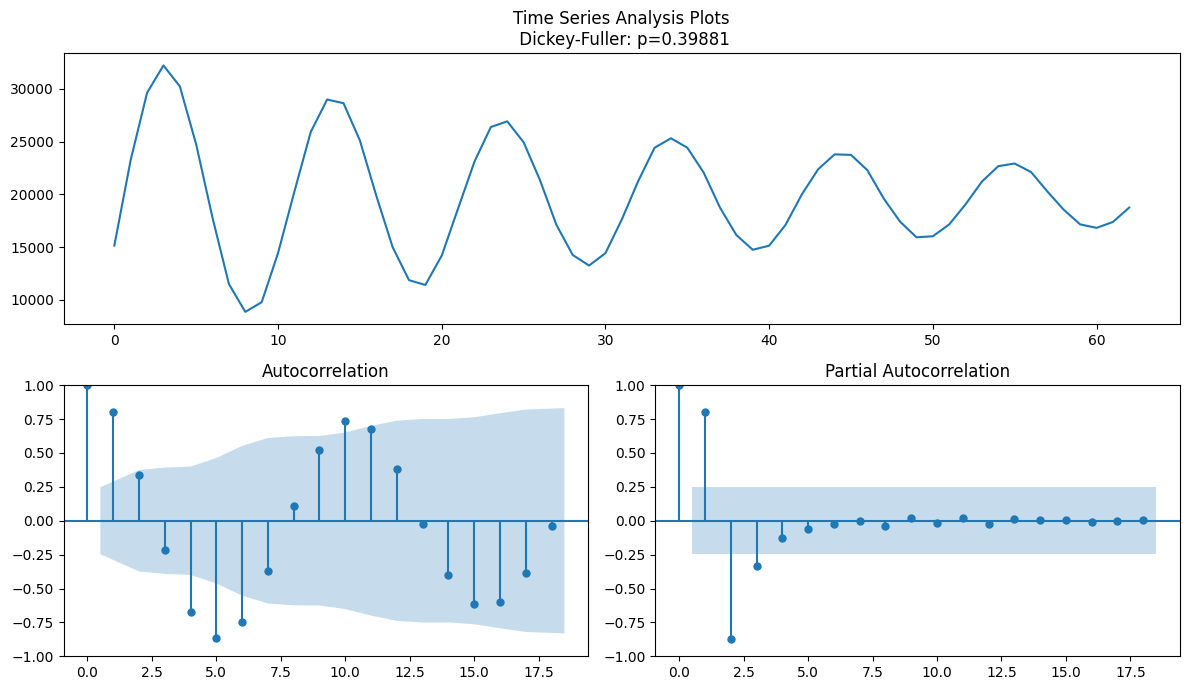

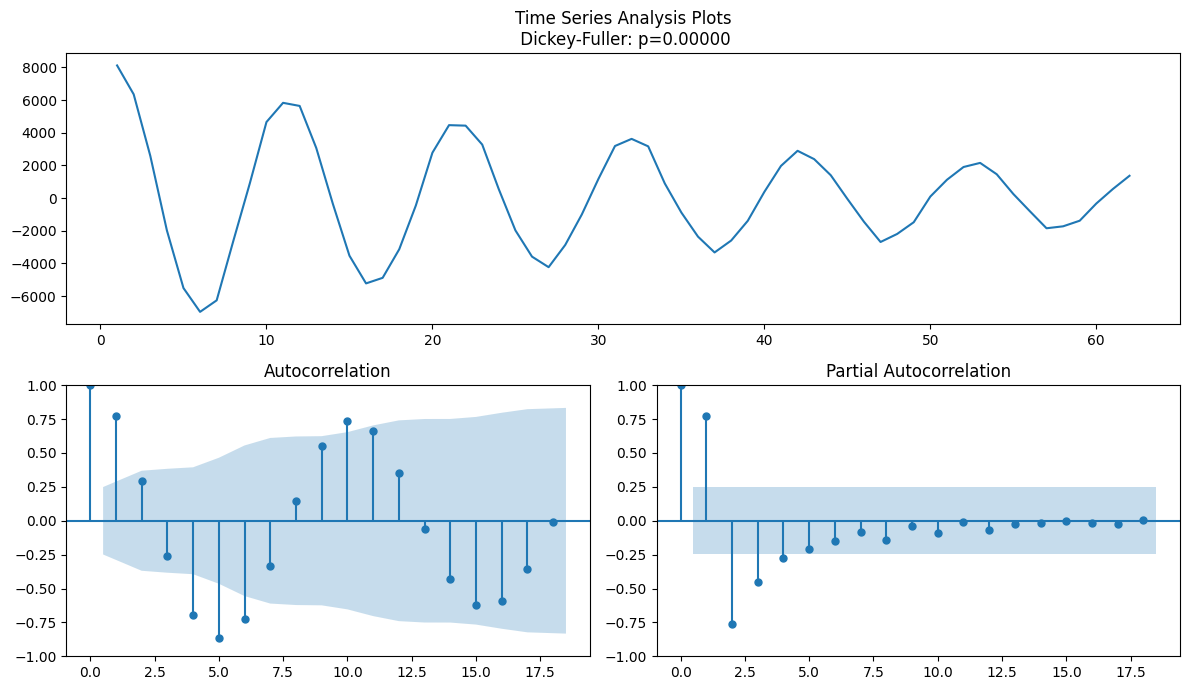

In [123]:
finresult.dropna(inplace=True)
tsplot(finresult['time_diff'])
finresult['newdiff']=finresult['time_diff'].diff()
finresult.dropna(inplace=True)
result2 = adfuller(finresult['newdiff'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])
tsplot(finresult['newdiff'])
finresult.reset_index(drop=True,inplace=True)
finresult

Thus I used ARIMA(3,1,10) model because of shapes of pacf and acf graphs

In [124]:

count = 0
for i in range(len(df_dropped_notmean2)):
  # Check if the value is a string and if it's empty or contains only whitespace
  value = df_dropped_notmean2.iloc[i, 0]
  if pd.isna(value):
    count-=1
  else:
    count+=1
print(count)

515


In [125]:
train, test = train_test_split(finresult, test_size=0.15, shuffle=False)

from statsmodels.tsa.arima.model import ARIMA
print("started")
model = ARIMA(train['time_diff'], order=(3,1,10))
print("started")
model_fit = model.fit()

started
started


c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE: 0.9389394383923457
MASE: 0.03556829063985146
R-squared: 0.998674457794694
MAPE: 0.8465763977615934
MASE: 0.07920734104143895
R-squared: 0.9913300597139739


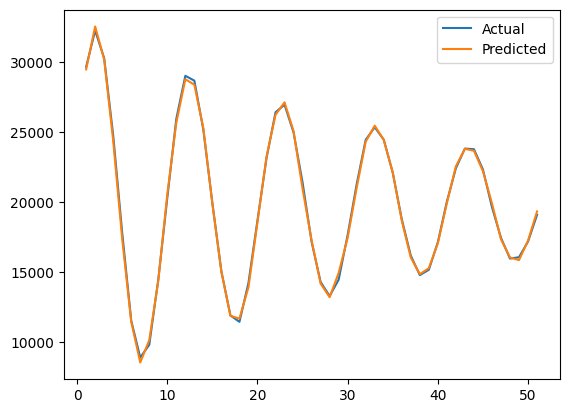

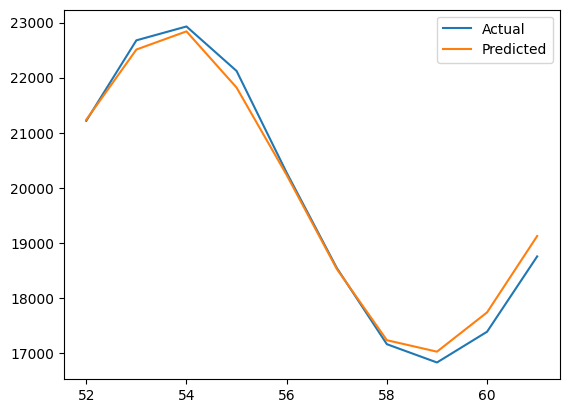

In [126]:
predictions_train = model_fit.predict(start=train.index[1], end=train.index[-1])

#Accuracy
mape_train = np.mean(np.abs((train['time_diff'].values[1:] - predictions_train) / train['time_diff'].values[1:])) * 100
print('MAPE:', mape_train)


mae_train = np.mean(np.abs(train['time_diff'].values[1:] - predictions_train))
naive_forecast = np.mean(train['time_diff'].values[1:])
mae_naive = np.mean(np.abs(train['time_diff'].values[1:] - naive_forecast))
mase_train = mae_train / mae_naive
print('MASE:', mase_train)


# Find rsquared
r2_train = 1 - np.sum((train['time_diff'].values[1:] - predictions_train) ** 2) / np.sum((train['time_diff'].values[1:] - np.mean(train['time_diff'].values)) ** 2)
print('R-squared:', r2_train)


predictions_test = model_fit.predict(start=test.index[0], end=test.index[-1])
#Accuracy
mape_test = np.mean(np.abs((test['time_diff'].values - predictions_test) / test['time_diff'].values)) * 100
print('MAPE:', mape_test)

mae_test = np.mean(np.abs(test['time_diff'].values - predictions_test))
naive_forecast = np.mean(test['time_diff'].values)
mae_naive = np.mean(np.abs(test['time_diff'].values - naive_forecast))
mase_test = mae_test / mae_naive
print('MASE:', mase_test)


# Find rsquared
r2_test = 1 - np.sum((test['time_diff'].values - predictions_test) ** 2) / np.sum((test['time_diff'].values - np.mean(test['time_diff'].values)) ** 2)
print('R-squared:', r2_test)


#Plot
#TRAIN
plt.plot(train['time_diff'][1:], label='Actual')
plt.plot(predictions_train, label='Predicted')
plt.legend()
plt.show()

#TEST
plt.plot(test['time_diff'], label='Actual')
plt.plot(predictions_test, label='Predicted')
plt.legend()
plt.show()


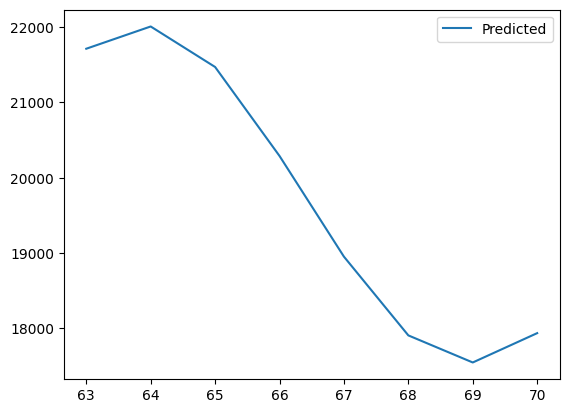

63    21713.973972
64    22009.523736
65    21471.446560
66    20289.445346
67    18951.980695
68    17905.679582
69    17546.032031
70    17935.725422
Name: predicted_mean, dtype: float64

In [127]:
final_predictions = model_fit.predict(start=63, end=70)
plt.plot(final_predictions, label='Predicted')
plt.legend()
plt.show()
final_predictions

## Method 2: Missing Value imputation + Outlier Smoothing by Moving Average

For this part we have applied moving average technique on the imputed data.

In [128]:
# This is similar to that in part (a)
#### Lets smooth the data to remove outliers using MA for the complete data
df1_smoothed3=finresult.copy()
df1_smoothed3['time_diff'] = finresult['time_diff'].rolling(window=2).mean()

#### fill nan with actual values
df1_smoothed3['time_diff'].fillna(finresult['time_diff'], inplace=True)
df1_smoothed3

C:\Users\Maadurga computer\AppData\Local\Temp\ipykernel_22132\1433281278.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1_smoothed3['time_diff'].fillna(finresult['time_diff'], inplace=True)


,date,time_diff,newdiff
0,2024-09-13,23275.730623,8125.039378
1,2024-09-14,26453.798724,6356.136203
2,2024-09-15,30927.066036,2590.398422
3,2024-09-16,31233.476946,-1977.576602
4,2024-09-17,27489.267399,-5510.842491
...,...,...,...
57,2024-11-09,19408.856555,-1728.351407
58,2024-11-10,17852.275701,-1384.810301
59,2024-11-11,16993.991995,-331.757110
60,2024-11-12,17107.221277,558.215674


ADF Statistic: -7.750202499985832
p-value: 1.0067566290563349e-11


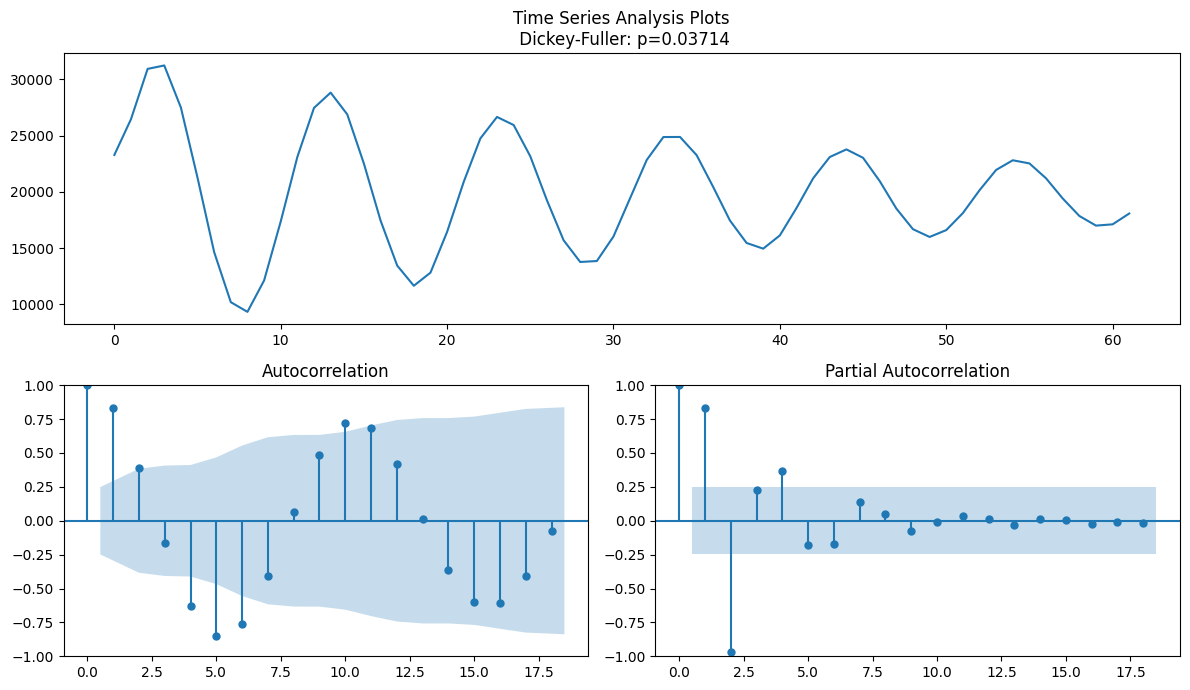

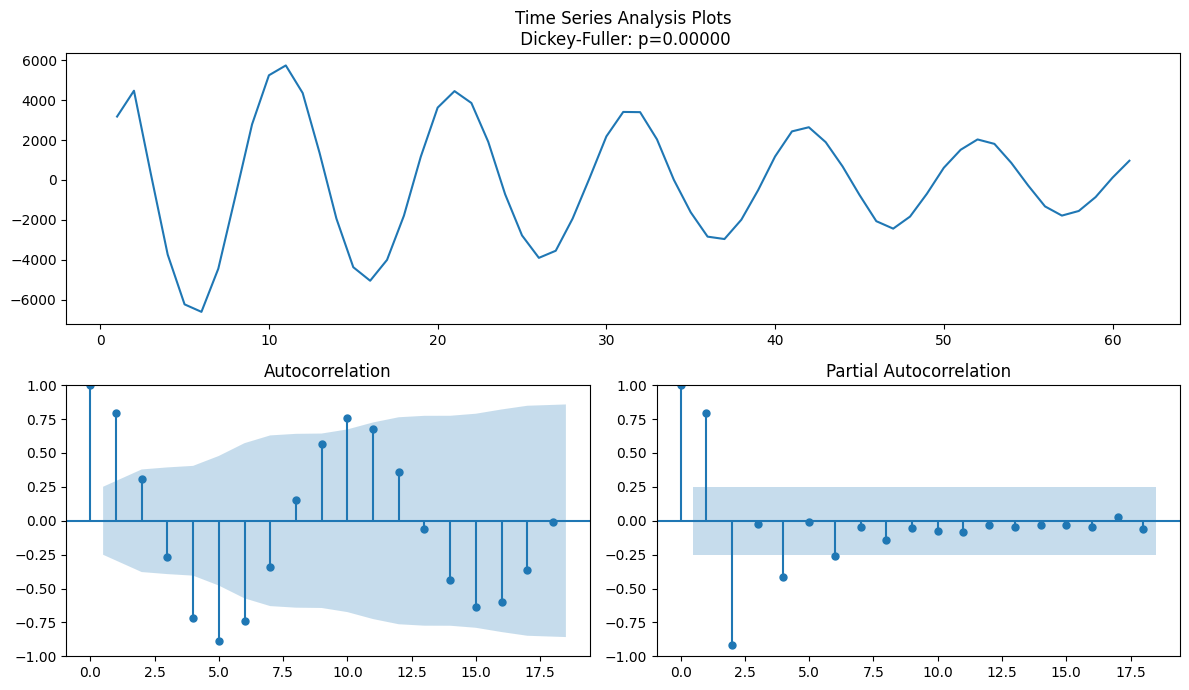

In [129]:
df1_smoothed3.dropna(inplace=True)
tsplot(df1_smoothed3['time_diff'])
df1_smoothed3['newdiff']=df1_smoothed3['time_diff'].diff()
df1_smoothed3.dropna(inplace=True)
result2 = adfuller(df1_smoothed3['newdiff'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])
tsplot(df1_smoothed3['newdiff'])
df1_smoothed3.reset_index(drop=True,inplace=True)

Thus I used ARIMA(3,1,10) model because of shapes of pacf and acf graphs

In [130]:

count = 0
for i in range(len(df_dropped_notmean2)):
  # Check if the value is a string and if it's empty or contains only whitespace
  value = df_dropped_notmean2.iloc[i, 0]
  if pd.isna(value):
    count-=1
  else:
    count+=1
print(count)

515


In [131]:
train, test = train_test_split(df1_smoothed3, test_size=0.15, shuffle=False)

from statsmodels.tsa.arima.model import ARIMA
print("started")
model = ARIMA(train['time_diff'], order=(3,1,10))
print("started")
model_fit = model.fit()

started
started


c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Maadurga computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE: 0.5799331630505821
MASE: 0.02652627759740896
R-squared: 0.9978935835000036
MAPE: 0.8772483779967191
MASE: 0.08606988054166137
R-squared: 0.9916514135428994


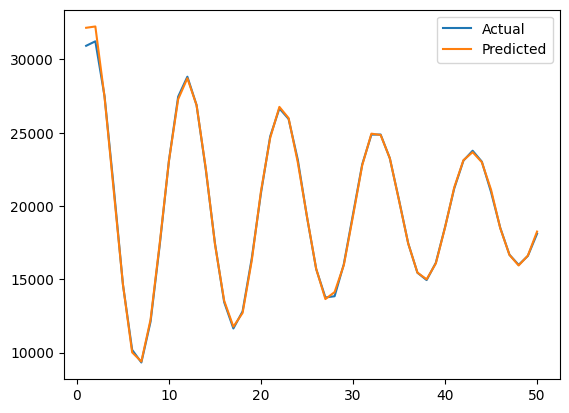

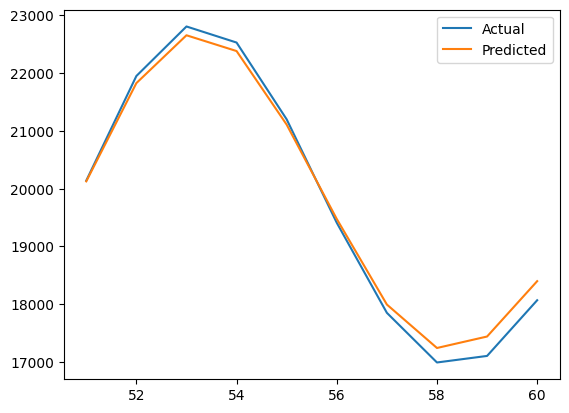

In [132]:
predictions_train = model_fit.predict(start=train.index[1], end=train.index[-1])

#Accuracy
mape_train = np.mean(np.abs((train['time_diff'].values[1:] - predictions_train) / train['time_diff'].values[1:])) * 100
print('MAPE:', mape_train)


mae_train = np.mean(np.abs(train['time_diff'].values[1:] - predictions_train))
naive_forecast = np.mean(train['time_diff'].values[1:])
mae_naive = np.mean(np.abs(train['time_diff'].values[1:] - naive_forecast))
mase_train = mae_train / mae_naive
print('MASE:', mase_train)


# Find rsquared
r2_train = 1 - np.sum((train['time_diff'].values[1:] - predictions_train) ** 2) / np.sum((train['time_diff'].values[1:] - np.mean(train['time_diff'].values)) ** 2)
print('R-squared:', r2_train)


predictions_test = model_fit.predict(start=test.index[0], end=test.index[-1])
#Accuracy
mape_test = np.mean(np.abs((test['time_diff'].values - predictions_test) / test['time_diff'].values)) * 100
print('MAPE:', mape_test)

mae_test = np.mean(np.abs(test['time_diff'].values - predictions_test))
naive_forecast = np.mean(test['time_diff'].values)
mae_naive = np.mean(np.abs(test['time_diff'].values - naive_forecast))
mase_test = mae_test / mae_naive
print('MASE:', mase_test)


# Find rsquared
r2_test = 1 - np.sum((test['time_diff'].values - predictions_test) ** 2) / np.sum((test['time_diff'].values - np.mean(test['time_diff'].values)) ** 2)
print('R-squared:', r2_test)


#Plot
#TRAIN
plt.plot(train['time_diff'][1:], label='Actual')
plt.plot(predictions_train, label='Predicted')
plt.legend()
plt.show()

#TEST
plt.plot(test['time_diff'], label='Actual')
plt.plot(predictions_test, label='Predicted')
plt.legend()
plt.show()


The accuracy is even better than that given by the first technique. Hence MA is effective for this data.

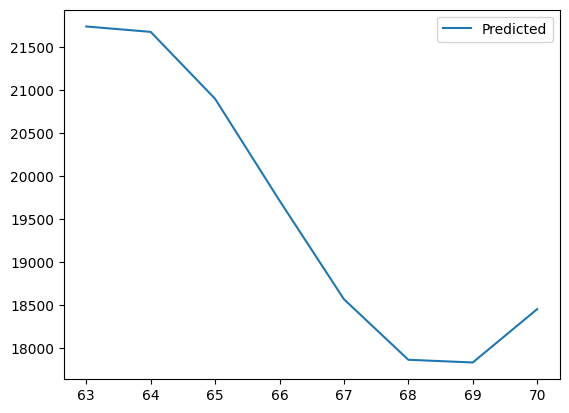

63    21741.908304
64    21679.077187
65    20899.560314
66    19714.864570
67    18566.320600
68    17861.256993
69    17829.712996
70    18450.872152
Name: predicted_mean, dtype: float64

In [133]:
final_predictions = model_fit.predict(start=63, end=70)
plt.plot(final_predictions, label='Predicted')
plt.legend()
plt.show()
final_predictions